## Theory
### Gated PixelCNN

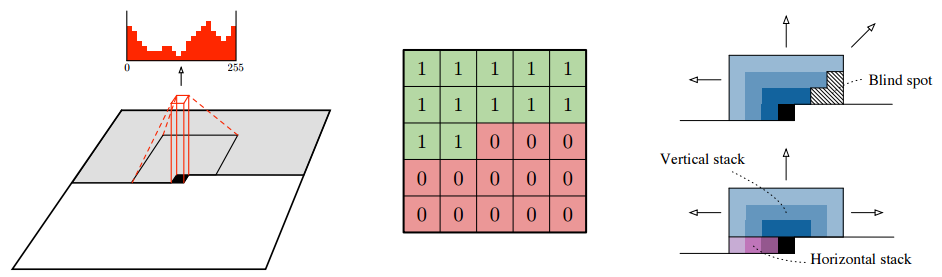

In [1]:
from PIL import Image
Image.open('./ConditionalGatedPixelCNN_masking.png')

For each pixel the three colour channels (R, G, B) are modelled successively, with B conditioned on (R, G), and G conditioned on R.
This is achieved by splitting the feature maps at every layer of the network into three and adjusting the
centre values of the mask tensors. The 256 possible values for each colour channel are then modelled
using a softmax.

During sampling the predictions are sequential: every time a pixel is predicted, it is fed back into the network to predict the next pixel.

### Gated Convolutional Layer  
$$ p(x) = \prod\limits^{n^2}_{i=1} p(x_i | x_1, ..., x_{i-1}) $$

$$ y = \tanh \left(W_{k,f} ∗ x\right) \odot σ\left(W_{k,g} ∗ x\right) $$

### Conditional PixelCNN  
$$ p(x|h) = \prod\limits^{n^2}_{i=1} p(x_i|x_1, ..., x_{i−1}, h) $$

- using a content (what) related latent representation

$$ y = \tanh\left(W_{k,f} ∗ x + V^T_{k,f}h\right) \odot σ\left(W_{k,g} ∗ x + V^T_{k,g} h\right)$$

If h is a one-hot encoding that specifies a class this is equivalent to
adding a class dependent bias at every layer. Notice that the conditioning does not depend on the
location of the pixel in the image; this is appropriate as long as h only contains information about
what should be in the image and not where. For example we could specify that a certain animal or
object should appear, but may do so in different positions and poses and with different backgrounds.

- using a location (where) related latent representation  

By mapping h to a spatial representation s = m (h) (which has the
same width and height as the image but may have an arbitrary number of feature maps) with a
deconvolutional neural network m(), we obtain a location dependent bias as follows

$$ y = \tanh\left(W_{k,f} ∗ x + V_{k,f} ∗ s\right) \odot σ\left(W_{k,g} ∗ x + V_{k,g} ∗ s\right) $$
where $V_{k,g}*s$ is an unmasked 1x1 covnolution

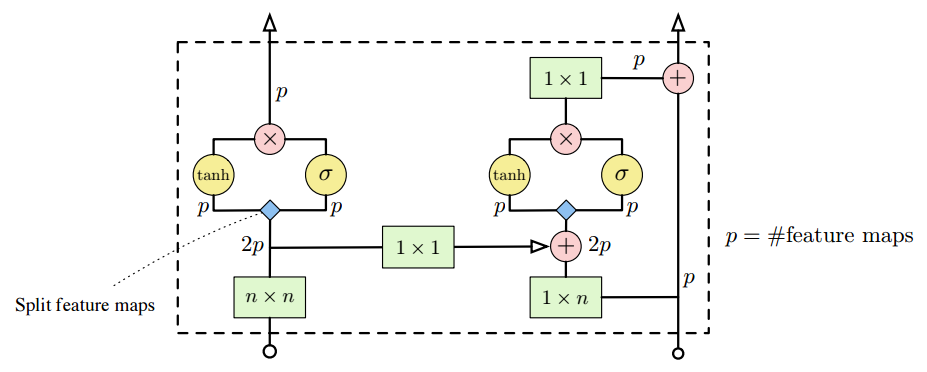

In [4]:
Image.open('./ConditionalGatedPixelCNN.png')

### Implementation

In [3]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer, Conv2DLayer, ElemwiseMergeLayer
from lasagne.nonlinearities import rectify
from collections import OrderedDict

import pixel_cnn
reload(pixel_cnn)
from pixel_cnn import *

Using gpu device 0: GeForce GTX 970M (CNMeM is disabled, cuDNN 5005)


In [4]:
input_shape = (3, 28, 28)
net = OrderedDict()
net['input'] = InputLayer((None, ) + input_shape)
net['input_conv'] = Conv2DLayer(net.values()[-1], num_filters=64, filter_size=7, name='input_conv')
cnn_block, l_vert, l_hor = build_pixelcnn_block(net.values()[-1], net.values()[-1], 3, 0, False)
net.update(cnn_block)

In [8]:
input_shape = (3, 28, 28)
pixel_cnn, out_l = build_pixel_cnn(input_shape, nfilts=384, fsize=5, n_layers=2, masked=True)

In [9]:
pixel_cnn_fn = theano.function([pixel_cnn['input'].input_var], lasagne.layers.get_output(out_l))

In [10]:
pixel_cnn_out = pixel_cnn_fn(np.random.rand(5, 3, 28, 28).astype('float32'))

In [11]:
pixel_cnn_out.shape

(5, 256, 22, 22)

## Non-masked

In [13]:
def get_mask(filter_shape=(1,1,6,6), mask_type='A'):
    fsize_new, fsize_old, rsize, csize = filter_shape
    mask = np.zeros((fsize_new, fsize_old, rsize*csize))
    limit = csize * (rsize // 2) + csize // 2
    mask[:, :, :limit+1] = 1
    
    pattern = np.zeros((3,3))
    idx = np.arange(3)
    if (mask_type == 'B'):
        idx = idx[:, None] >= idx[None]
    else:
        idx = idx[:, None] > idx[None]

    pattern[idx] = 1
    pattern = pattern[:, np.arange(fsize_old) % 3][np.arange(fsize_new) % 3]
    
    mask[:, :, limit] *= pattern[:, :]
    mask = mask.reshape(filter_shape)
    return mask.astype(theano.config.floatX)

In [69]:
input_shape = (1, 5, 5)
inp_l = InputLayer((None, ) + input_shape)
nfilts = 1
fsize = 3
W = lasagne.init.Constant(1.)

In [70]:
conv_masked = Conv2DLayer(inp_l, num_filters=2*nfilts, filter_size=fsize,
                          pad='same', nonlinearity=linear, W=W)
f_shape = conv_masked.W.get_value(borrow=True).shape
conv_masked.W *= get_mask(f_shape, 'A')

In [82]:
f_shape

(2, 1, 3, 3)

In [80]:
get_mask(f_shape, 'A')

array([[[[ 1.,  1.,  1.],
         [ 1.,  0.,  0.],
         [ 0.,  0.,  0.]]],


       [[[ 1.,  1.,  1.],
         [ 1.,  1.,  0.],
         [ 0.,  0.,  0.]]]], dtype=float32)

In [71]:
conv_masked_fn = theano.function([inp_l.input_var], lasagne.layers.get_output(conv_masked),
                                 allow_input_downcast=True)

In [72]:
masked_out = conv_masked_fn(np.ones((1, 1, 5, 5)).astype('float32'))
masked_out.shape

(1, 2, 5, 5)

In [73]:
conv_non_masked = Conv2DLayer(inp_l, num_filters=2*nfilts, filter_size=(fsize//2+1, fsize),
                              pad=(fsize//2+1, fsize//2), nonlinearity=linear, W=W)

# crop
sliced = SliceLayer(conv_non_masked, indices=slice(0, -fsize//2-1), axis=2, name='slice_vert')

In [77]:
# conv_unmasked_fn = theano.function([inp_l.input_var], lasagne.layers.get_output(sliced),
conv_unmasked_fn = theano.function([inp_l.input_var], lasagne.layers.get_output(conv_non_masked),
                                   allow_input_downcast=True)

In [78]:
unmasked_out = conv_unmasked_fn(np.ones((1, 1, 5, 5)).astype('float32'))
unmasked_out.shape

(1, 2, 8, 5)

In [79]:
zip(masked_out, unmasked_out)

[(array([[[ 3.,  4.,  4.,  4.,  2.],
          [ 3.,  4.,  4.,  4.,  2.],
          [ 3.,  4.,  4.,  4.,  2.],
          [ 3.,  4.,  4.,  4.,  2.],
          [ 1.,  1.,  1.,  1.,  0.]],
  
         [[ 4.,  5.,  5.,  5.,  3.],
          [ 4.,  5.,  5.,  5.,  3.],
          [ 4.,  5.,  5.,  5.,  3.],
          [ 4.,  5.,  5.,  5.,  3.],
          [ 2.,  2.,  2.,  2.,  1.]]], dtype=float32),
  array([[[ 0.,  0.,  0.,  0.,  0.],
          [ 2.,  3.,  3.,  3.,  2.],
          [ 4.,  6.,  6.,  6.,  4.],
          [ 4.,  6.,  6.,  6.,  4.],
          [ 4.,  6.,  6.,  6.,  4.],
          [ 4.,  6.,  6.,  6.,  4.],
          [ 2.,  3.,  3.,  3.,  2.],
          [ 0.,  0.,  0.,  0.,  0.]],
  
         [[ 0.,  0.,  0.,  0.,  0.],
          [ 2.,  3.,  3.,  3.,  2.],
          [ 4.,  6.,  6.,  6.,  4.],
          [ 4.,  6.,  6.,  6.,  4.],
          [ 4.,  6.,  6.,  6.,  4.],
          [ 4.,  6.,  6.,  6.,  4.],
          [ 2.,  3.,  3.,  3.,  2.],
          [ 0.,  0.,  0.,  0.,  0.]]], dtype=floa

In [54]:
np.allclose(masked_out, unmasked_out)

False

## PixelCNN Auto-encoder

In [8]:
import sys
sys.path.append('/home/adrian/PycharmProjects/Lasagne/modelzoo/')

In [9]:
from googlenet import build_model

In [1]:
def build_encoder(specs, latent='global'):
    net = build_model() # imagenet shit
    net.pop('classifier')
    
    if latent == 'global':
        net['latent'] = DenseLayer(net.values()[-1], num_units=specs, name='global latent')
    elif latent == 'local':
        nfilts, fsize = specs
        net['latent'] = Conv2DLayer(net.values()[-1], num_filters=nfilts, filter_size=fsize,
                                    non_linearity=softmax, name='local latent')
    return net, net['latent']

In [ ]:
encoder, latent_layer = build_encoder(specs, latent='global')
pixel_cnn, out_l = build_pixel_cnn(input_shape=INPUT_SHAPE, n_layers=num_layers, masked=False, latent=latent_layer)

### References:  
original paper - http://arxiv.org/pdf/1606.05328v1.pdf  
other (partial) implementation - https://github.com/kundan2510/pixelCNN/blob/master/layers.py